## Inisialisasi 

In [2]:
import pandas as pd

## Memuat Data

Dataset disimpan di folder `/datasets/faces/`. Pada folder tersebut, terdapat: - Folder `final_file` dengan 7,6 ribu foto 
- File `labels.csv` yang memuat label, dengan dua kolom: `file_name` dan `real_age` 

In [3]:
labels_df = pd.read_csv('/datasets/faces/labels.csv')

## EDA

In [4]:
labels_df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [4]:
labels_df.shape

(7591, 2)

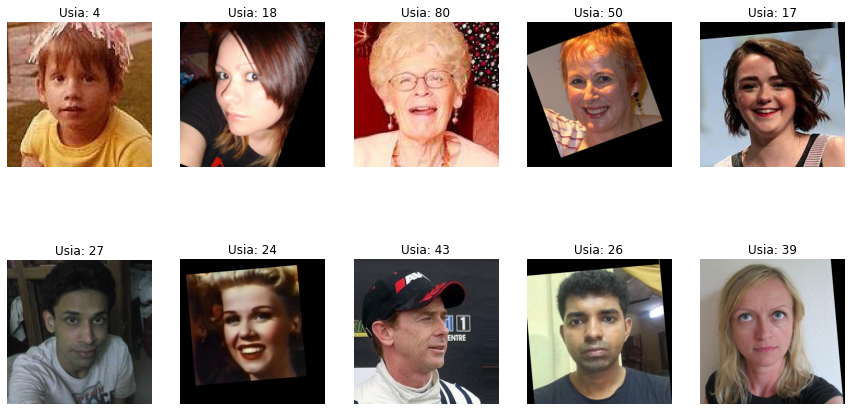

In [5]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
unique_ages = labels_df['real_age'].unique()
sample_ages = unique_ages[:10]
plt.figure(figsize=(15, 8))
for i, age in enumerate(sample_ages, 1):
    plt.subplot(2, 5, i)
    img_path = labels_df[labels_df['real_age'] == age]['file_name'].iloc[0]
    img = load_img('/datasets/faces/final_files/' + img_path)
    plt.imshow(img)
    plt.title(f'Usia: {age}')
    plt.axis('off')
plt.show()

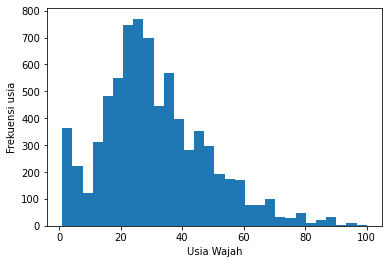

In [6]:
plt.hist(labels_df['real_age'], bins= 30)
plt.xlabel('Usia Wajah')
plt.ylabel('Frekuensi usia')
plt.show()

### Temuan

Berdasarkan eksplorasi data, diketemukan bahwa data kita memiliki 7600 data dengan rata-rata usia 31 tahun. Rentang data usia yang tersedia adalah 1 hingga seratus tahun. Berdasarkan pengamatan histogram, terlihat bahwa rentang usia tidak memiliki angka yang tidak wajar dan data paling banyak terdapat dalam kelas 20-40 tahun. 

## Pemodelan 

Definisikan fungsi-fungsi yang diperlukan untuk melatih modelmu pada platform GPU dan buat satu skrip yang berisi semua fungsi tersebut beserta bagian inisialisasi.
Untuk mempermudah tugas ini, kamu bisa mendefinisikannya dalam notebook ini dan menjalankan kode siap pakai di bagian berikutnya untuk menyusun skrip secara otomatis.
Oh ya, definisi di bawah ini juga akan diperiksa oleh project reviewer agar mereka bisa memahami caramu membangun model.

In [10]:

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [11]:
def load_train(path):
    
    labels = pd.read_csv(path+'labels.csv')                                                     
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25,
                                      horizontal_flip=True, vertical_flip=True)  
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

In [12]:
def load_test(path):
    
    labels = pd.read_csv(path+'labels.csv')  
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)  
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation', 
        seed=12345)

    return test_gen_flow

In [14]:
def create_model(input_shape):
    
    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet', 
                    include_top= False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', 
                  metrics=['mae'])

    return model

In [15]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model


## Siapkan Skrip untuk menjalankan platform GPU

Setelah  fungsi-fungsi yang diperlukan didefinisikan, buat skrip untuk platform GPU, mengunduhnya melalui menu "File|Open...", dan mengunggahnya nanti untuk dijalankan pada platform GPU. "


In [16]:
# siapkan skrip untuk menjalankan platform GPU


init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Letakkan output dari platform GPU sebagai sel Markdown di sini.

Epoch 1/10
178/178 - 59s - loss: 266.4289 - mae: 11.8350 - val_loss: 1013.7747 - val_mae: 27.1554

Epoch 2/10
178/178 - 38s - loss: 103.6963 - mae: 7.7102 - val_loss: 725.6781 - val_mae: 21.9204

Epoch 3/10
178/178 - 38s - loss: 78.2975 - mae: 6.6751 - val_loss: 256.5587 - val_mae: 11.9050

Epoch 4/10
178/178 - 38s - loss: 67.3339 - mae: 6.1922 - val_loss: 240.9254 - val_mae: 12.5940

Epoch 5/10
178/178 - 38s - loss: 53.5407 - mae: 5.5122 - val_loss: 95.7937 - val_mae: 7.3004

Epoch 6/10
178/178 - 38s - loss: 47.2012 - mae: 5.2266 - val_loss: 81.9444 - val_mae: 6.7211

Epoch 7/10
178/178 - 38s - loss: 39.8793 - mae: 4.8017 - val_loss: 74.1807 - val_mae: 6.5123

Epoch 8/10
178/178 - 38s - loss: 32.5789 - mae: 4.3509 - val_loss: 105.1823 - val_mae: 8.0194

Epoch 9/10
178/178 - 38s - loss: 30.8503 - mae: 4.2103 - val_loss: 84.2016 - val_mae: 7.0812

Epoch 10/10
178/178 - 38s - loss: 25.0876 - mae: 3.8544 - val_loss: 85.5688 - val_mae: 6.7789


60/60 - 9s - loss: 85.5688 - mae: 6.7789
Test MAE: 6.7789

## Kesimpulan

Model terdiri atas empat fungsi yaitu model untuk memuat data training, data tes, pembuatan algoritma model, dan pelatihan model. Data training dan data tes dibuat menggunakan subset dari direktori final_files yang dienumerasi menggunakan label dari labels_df untuk menghasilkan subset training dan subset tes. Model dibuat dengan menggunakan kerangka Resnet 50 dengan optimasi Adam (lr= 0.001) dan menggunakan parameter mean absolute error untuk mengevaluasi ketepatan model. Setelah dijalankan menggunakan pada platform GPU, model menunjukkan nilai mae hingga 6,78. Nilai mae ini menunjukkan ketepatan prediksi yang tinggi dan sangat 